##  stock-model


机器学习工具Scikit Learn介绍
这里我们将利用Scikit Learn对苹果公司的秒级股票报价进行建模，并以此为例
熟悉Scikit Learn的各个模块。

In [7]:
import pandas as pd 

import numpy as np

from sklearn.preprocessing import Imputer, PolynomialFeatures
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, median_absolute_error
from timeseriesutil import TimeSeriesDiff, TimeSeriesEmbedder, ColumnExtractor

import matplotlib.pyplot as plt 
import matplotlib 

matplotlib.style.use('ggplot')
plt.xticks(rotation=70)

(array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 6 Text xticklabel objects>)

### 数据导入
这里我们导入经过了预处理的苹果公司股票报价，该数据仅包含正常交易时间的
数据。

In [5]:
data = pd.read_csv("aapl-trading-hour.csv",
                   index_col = 0)

y = data["Close"].diff() / data["Close"].shift()

y[np.isnan(y)]=0

n_total = data.shape[0]
n_train = int(np.ceil(n_total*0.7))

data_train = data[:n_train]
data_test  = data[n_train:]

y_train = y[10:n_train]
y_test  = y[(n_train+10):]

### 利用Pipeline实现建模

In [8]:

pipeline = Pipeline([("ColumnEx", ColumnExtractor("Close")),
                     ("Diff", TimeSeriesDiff()),
                     ("Embed", TimeSeriesEmbedder(10)),
                     ("ImputerNA", Imputer()),
                     ("LinReg", LinearRegression())])
                    
pipeline.fit(data_train, y_train)
y_pred = pipeline.predict(data_test)

### 查看并评价结果

0.0337101433762
5.13187925933e-05


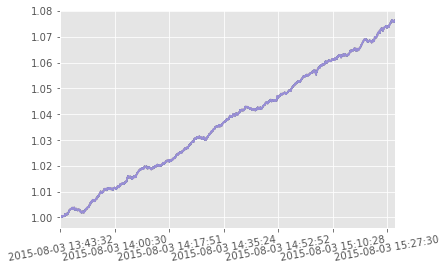

In [11]:


print(r2_score(y_test, y_pred))
print(median_absolute_error(y_test, y_pred))

cc = np.sign(y_pred)*y_test
cumulative_return = (cc+1).cumprod()
cumulative_return.plot(rot=10)
plt.savefig("performance-simple-linreg.png")
plt.show()

0.00571206779688
5.17837109633e-05


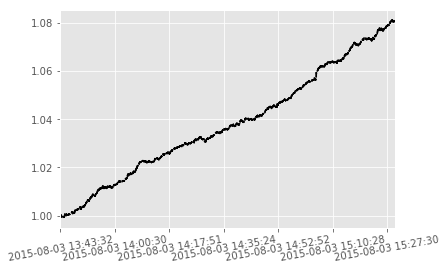

In [13]:
"""更复杂的Pipeline
我们试图将成交量也纳入考虑，所以需要进行多个pipeline的融合。
同时，我们试图引入多远交互项，以考虑非线性相关关系。
"""

pipeline_closing_price = Pipeline([("ColumnEx", ColumnExtractor("Close")),
                                   ("Diff", TimeSeriesDiff()),
                                   ("Embed", TimeSeriesEmbedder(10)),
                                   ("ImputerNA", Imputer())])

pipeline_volume = Pipeline([("ColumnEx", ColumnExtractor("Volume")),
                            ("Diff", TimeSeriesDiff()),
                            ("Embed", TimeSeriesEmbedder(10)),
                            ("ImputerNA", Imputer())])

merged_features = FeatureUnion([("ClosingPriceFeature", pipeline_closing_price),
                                ("VolumeFeature", pipeline_volume)])

pipeline_2 = Pipeline([("MergedFeatures", merged_features),
                       ("PolyFeature",PolynomialFeatures()),
                       ("LinReg", LinearRegression())])
pipeline_2.fit(data_train, y_train)

y_pred_2 = pipeline_2.predict(data_test)

print(r2_score(y_test, y_pred_2))
print(median_absolute_error(y_test, y_pred_2))

cc_2 = np.sign(y_pred_2)*y_test
cumulative_return_2 = (cc_2+1).cumprod()
cumulative_return_2.plot(style="k--", rot=10)
plt.savefig("performance-more-variables.png")
plt.show()

### 预测运行时间

In [14]:


import time
start_time = time.clock()
pipeline_2.predict(data_test[1:20])
print(time.clock() - start_time, "seconds")

0.01411254145724953 seconds
